In [1]:
from data_preprocessing.dataloader import loading_data
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('--padding', type=str, 
                    default='mean', help='choose one of them : no, max, mean')
parser.add_argument('--timespan', type=int, 
                    default=10000, help='choose of the number of timespan between data points(1000 = 1sec, 60000 = 1min)')
parser.add_argument('--min_seq', type=int, 
                    default=10, help='choose of the minimum number of data points in a example')
parser.add_argument('--min_samples', type=int, default=20, 
                    help='choose of the minimum number of samples in each label')
parser.add_argument('--selected_dataset', default='lapras', type=str,
                    help='Dataset of choice: lapras, casas, opportunity, aras_a, aras_b')
parser.add_argument('--aug_method', type=str, default='AddNoise', help='choose the data augmentation method')
parser.add_argument('--aug_wise', type=str, default='Temporal', help='choose the data augmentation wise')

parser.add_argument('--test_ratio', type=float, default=0.3, help='choose the number of test ratio')

args = parser.parse_args(args=[])
data_type = args.selected_dataset

# DOO-RE
num_classes_DR, datalist_DR, labellist_DR = loading_data('lapras', args)
print(datalist_DR.shape)

# CASAS
num_classes_CS, datalist_CS, labellist_CS = loading_data('casas', args)
print(datalist_CS.shape)

Loading Lapras Dataset--------------------------------------
['Seat Occupy', 'Sound', 'Brightness', 'Light', 'Existence', 'Projector', 'Presentation']
Loading Lapras Dataset Finished--------------------------------------
types_label : [1, 2, 3, 4]
count_label : [119, 52, 40, 129]
sum of # episodes: 340
----------------------------------------------------------------------------------------------------
*****Remining data labels:  [1, 2, 3, 4]
----------------------------------------------------------------------------------------------------
*****Changed data labels*****
types_label : [1, 2, 3, 4]
count_label : [119, 52, 40, 129]
sum of # episodes: 340
original label: [1, 2, 3, 4] 
changed label: [1, 2, 3, 4]
----------------------------------------------------------------------------------------------------
*****Augmentation Starting*****
types_label : [1, 2, 3, 4]
count_label : [119, 52, 40, 129]
sum of # episodes: 340
The amount of augmented data: [10, 77, 89, 0]
--------------------

In [ ]:



# Opportunity
args.timespan = 1000
num_classes_OP, datalist_OP, labellist_OP = loading_data('opportunity', args)
print(datalist_OP.shape)

# ARAS_A
num_classes_AA, datalist_AA, labellist_AA = loading_data('aras_a', args)
print(datalist_AA.shape)


In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
from data_preprocessing.dataloader import count_label_labellist

import torch
import matplotlib.pyplot as plt
import pandas as pd

def tsne_visualization(data_list, label_list, dataset, dim):

    label_list = torch.tensor(label_list).tolist()
    num_classes, _ = count_label_labellist(label_list)
    
    #print('Shaped x', data_list.shape) #Shaped x torch.Size([676, 87, 7])
    #print(label_list) #[1,1,1,...]
    #print(type(data_list)) #Reshaped x torch.Size([676, 609])
    if(dim>=3):
        x_rs = np.reshape(data_list, [data_list.shape[0], data_list.shape[1]*data_list.shape[2]])
    else:
        label_list = (np.array(label_list)+1).tolist()
        x_rs = data_list.detach().numpy() 
    print('Reshaped x', x_rs.shape)
    print(type(x_rs))

    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    z = tsne.fit_transform(x_rs)
    df = pd.DataFrame()
    df["label"] = label_list    
    df["tsne_1"] = z[:,0]
    df["tsne_2"] = z[:,1]
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', palette=sns.color_palette("hls",len(num_classes)),
                    data=df, ax=ax,s=120).set(title= dataset+" data T-SNE projection")
#    splot  = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
    #            palette=sns.color_palette("hls",len(num_classes)), data=df).set(title= dataset+" data T-SNE projection")
    #plt.savefig('figure/'+ dataset +'-tsne.png', dpi=300)
    # clear the plot 
    #plt.cla()
    lim = (z.min()-5, z.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0) 

In [ ]:
#tsne_visualization(datalist_DR.cpu(), labellist_DR, 'lapras', 3)

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from models.model import TransformerEncoder
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

ood_idx = 3
class Load_Dataset(Dataset):
    # Initialize your data, download, etc.
    def __init__(self, data_list, label_list):
        super(Load_Dataset, self).__init__()

        self.x_data = data_list
        self.y_data = label_list

        self.len = self.x_data.shape[0]
        

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

# Training Function
def train(dataloader, model, criterion, optimizer):
    'for one epoch training'
    model.train()
   
    # for each batch
    for idx, (data, labels) in enumerate(dataloader):
    
        data = data.cuda()
        labels = labels.cuda()
        # batch size
        bsz = labels.shape[0]
      
        # forward + backward + optimize
        output = model(data)
        loss = criterion(output, labels)

        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return model

train_list, test_list, train_label_list, test_label_list = train_test_split(datalist_DR, 
                    labellist_DR, test_size=0.4, stratify= labellist_DR, random_state=42) 

train_list = torch.tensor(train_list).cuda().cpu()
train_label_list = torch.tensor(train_label_list).cuda().cpu()

test_list = torch.tensor(test_list).cuda().cpu()
test_label_list = torch.tensor(test_label_list).cuda().cpu()

# sequence is important!
valid_list = train_list[np.where(train_label_list == ood_idx)]
valid_label_list = train_label_list[np.where(train_label_list == ood_idx)]

train_list = train_list[np.where(train_label_list != ood_idx)]
train_label_list = train_label_list[np.where(train_label_list != ood_idx)]

dataset = Load_Dataset(train_list, train_label_list)    
train_dl = DataLoader(dataset, batch_size=64, shuffle=True)

tsne_visualization(train_list , train_label_list , 'DOO-RE 1', 3)

#dataset = Load_Dataset(test_list, test_label_list)
#test_dl = DataLoader(dataset, batch_size=64, shuffle=True)

# setup
model = TransformerEncoder(num_classes=len(num_classes_DR), 
        feature_dim= len(train_list[0][0]), dim=64).cuda()
criterion = nn.CrossEntropyLoss()

# set optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)
# set scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

# first training
for epoch in range(15):
    model = train(train_dl, model, criterion, optimizer)

# for testing
model.eval()
output = model(valid_list.cuda())
#tsne_visualization(output.cpu(), valid_label_list, 'DOO-RE', 2)

#tsne_visualization(output[np.where(test_label_list != ood_idx)].cpu(), test_label_list[np.where(test_label_list != ood_idx)], 'DOO-RE RS1', 2)

final_rs = output.argmax(dim=1).cpu()

output_test = model(test_list[np.where(test_label_list != ood_idx)].cuda())
tsne_visualization(output_test.cpu(), 
                   test_label_list[np.where(test_label_list != ood_idx)], 'DOO-RE RS1', 2)

#tsne_visualization(output.cpu(), final_rs, 'DOO-RE', 2)

train_list = torch.cat((train_list, valid_list), 0)
train_label_list = torch.cat((train_label_list,  final_rs), 0)

dataset = Load_Dataset(train_list, train_label_list)    
train_dl = DataLoader(dataset, batch_size=64, shuffle=True)

tsne_visualization(train_list , train_label_list , 'DOO-RE 2', 3)


# setup
model = TransformerEncoder(num_classes=len(num_classes_DR), 
        feature_dim= len(train_list[0][0]), dim=64).cuda()
criterion = nn.CrossEntropyLoss()

# set optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)
# set scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

# retraining
for epoch in range(15):
    model = train(train_dl, model, criterion, optimizer)

# for testing
model.eval()
output = model(test_list.cuda())
tsne_visualization(output.cpu(), test_label_list, 'DOO-RE', 2)

# without 
tsne_visualization(output[np.where(test_label_list != ood_idx)].cpu(), 
                   test_label_list[np.where(test_label_list != ood_idx)], 'DOO-RE RS2', 2)


#final_rs = output.argmax(dim=1).cpu().detach().numpy()

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from models.model import TransformerEncoder
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

ood_idx = 12
class Load_Dataset(Dataset):
    # Initialize your data, download, etc.
    def __init__(self, data_list, label_list):
        super(Load_Dataset, self).__init__()

        self.x_data = data_list
        self.y_data = label_list

        self.len = self.x_data.shape[0]
        

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

# Training Function
def train(dataloader, model, criterion, optimizer):
    'for one epoch training'
    model.train()
   
    # for each batch
    for idx, (data, labels) in enumerate(dataloader):
    
        data = data.cuda()
        labels = labels.cuda()
        # batch size
        bsz = labels.shape[0]
      
        # forward + backward + optimize
        output = model(data)
        loss = criterion(output, labels)

        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return model

train_list, test_list, train_label_list, test_label_list = train_test_split(datalist_CS, 
                    labellist_CS, test_size=0.4, stratify= labellist_CS, random_state=42) 

train_list = torch.tensor(train_list).cuda().cpu()
train_label_list = torch.tensor(train_label_list).cuda().cpu()

test_list = torch.tensor(test_list).cuda().cpu()
test_label_list = torch.tensor(test_label_list).cuda().cpu()

# sequence is important!
valid_list = train_list[np.where(train_label_list == ood_idx)]
valid_label_list = train_label_list[np.where(train_label_list == ood_idx)]

train_list = train_list[np.where(train_label_list != ood_idx)]
train_label_list = train_label_list[np.where(train_label_list != ood_idx)]

dataset = Load_Dataset(train_list, train_label_list)    
train_dl = DataLoader(dataset, batch_size=64, shuffle=True)

tsne_visualization(train_list , train_label_list , 'DOO-RE 1', 3)

#dataset = Load_Dataset(test_list, test_label_list)
#test_dl = DataLoader(dataset, batch_size=64, shuffle=True)

# setup
model = TransformerEncoder(num_classes=len(num_classes_CS), 
        feature_dim= len(train_list[0][0]), dim=64).cuda()
criterion = nn.CrossEntropyLoss()

# set optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)
# set scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

# first training
for epoch in range(100):
    model = train(train_dl, model, criterion, optimizer)

# for testing
model.eval()
output = model(valid_list.cuda())
#tsne_visualization(output.cpu(), valid_label_list, 'DOO-RE', 2)

#tsne_visualization(output[np.where(test_label_list != ood_idx)].cpu(), test_label_list[np.where(test_label_list != ood_idx)], 'DOO-RE RS1', 2)

final_rs = output.argmax(dim=1).cpu()

output_test = model(test_list[np.where(test_label_list != ood_idx)].cuda())
tsne_visualization(output_test.cpu(), 
                   test_label_list[np.where(test_label_list != ood_idx)], 'DOO-RE RS1', 2)

#tsne_visualization(output.cpu(), final_rs, 'DOO-RE', 2)

train_list = torch.cat((train_list, valid_list), 0)
train_label_list = torch.cat((train_label_list,  final_rs), 0)

dataset = Load_Dataset(train_list, train_label_list)    
train_dl = DataLoader(dataset, batch_size=64, shuffle=True)

tsne_visualization(train_list , train_label_list , 'DOO-RE 2', 3)


# setup
model = TransformerEncoder(num_classes=len(num_classes_CS), 
        feature_dim= len(train_list[0][0]), dim=64).cuda()
criterion = nn.CrossEntropyLoss()

# set optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)
# set scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

# retraining
for epoch in range(100):
    model = train(train_dl, model, criterion, optimizer)

# for testing
model.eval()
output = model(test_list.cuda())
tsne_visualization(output.cpu(), test_label_list, 'DOO-RE', 2)

# without 
tsne_visualization(output[np.where(test_label_list != ood_idx)].cpu(), 
                   test_label_list[np.where(test_label_list != ood_idx)], 'DOO-RE RS2', 2)


#final_rs = output.argmax(dim=1).cpu().detach().numpy()

torch.Size([516, 598, 7])
[1, 2, 3, 4]


/home/juice/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


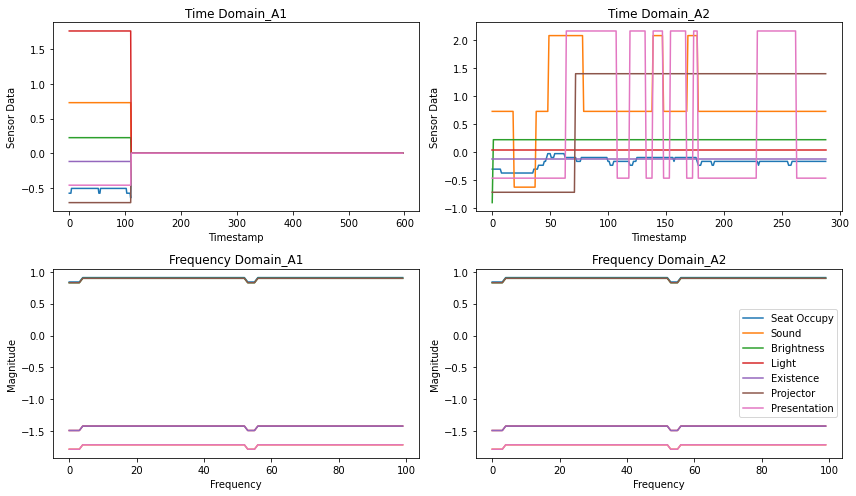

In [2]:
# Visualization for DOO-RE
import numpy as np
import matplotlib.pyplot as plt
from tsaug import *
import torch

# [119, 52, 40, 129]
print(datalist_DR.shape)
print(num_classes_DR)

# 입력 데이터 생성
input_data_1 = datalist_DR[20][:400, :].cpu().numpy()  # Activity 1
input_data_2 = datalist_DR[314][11:300, : ].cpu().numpy()  # Activity 2

#99

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 2, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

# 주파수 도메인 데이터 시각화
freq_data_1 = torch.fft.fft(torch.from_numpy(input_data_2))
freq_data_2 = torch.fft.fft(torch.from_numpy(input_data_2)).abs()

plt.subplot(2, 2, 3)
plt.plot(freq_data_1[:100])
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
plt.plot(freq_data_2[:100])
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.legend(['Seat Occupy', 'Sound', 'Brightness', 'Light', 'Existence', 'Projector', 'Presentation']) 
plt.tight_layout()
plt.show()


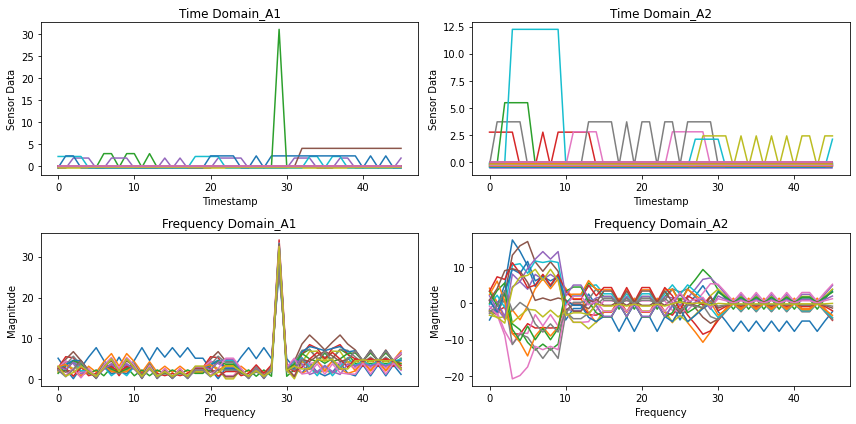

In [20]:
# Visualization for CASAS
import numpy as np
import matplotlib.pyplot as plt
from tsaug import *


# 입력 데이터 생성
input_data_1 = datalist_CS[30][:200 , : ].cpu().numpy()  # Activity 1
input_data_2 = datalist_CS[317].cpu().numpy()  # Activity 2

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 2, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")



# 주파수 도메인 데이터 시각화
freq_data_1 = np.abs(np.fft.rfft((input_data_1)))
freq_data_2 = np.fft.rfft((input_data_2))

plt.subplot(2, 2, 3)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
plt.plot(freq_data_2)
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()


In [ ]:
# Visualization for Opportunity
import numpy as np
import matplotlib.pyplot as plt
from tsaug import *


# 입력 데이터 생성
input_data_1 = datalist_OP[30][:200 , : ].cpu().numpy()  # Activity 1
input_data_2 = datalist_OP[20].cpu().numpy()  # Activity 2

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 2, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")



# 주파수 도메인 데이터 시각화
freq_data_1 = np.fft.rfft((input_data_1))
#print(fre)
freq_data_2 = np.fft.rfft((input_data_2.T)).T


plt.subplot(2, 2, 3)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
plt.plot(freq_data_2)
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()

In [ ]:
# Visualization for ARAS_A
import numpy as np
import matplotlib.pyplot as plt
from tsaug import *


# 입력 데이터 생성
input_data_1 = datalist_AA[30][:200 , : ].cpu().numpy()  # Activity 1
input_data_2 = datalist_AA[70].cpu().numpy()  # Activity 2

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 2, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")



# 주파수 도메인 데이터 시각화
freq_data_1 = np.fft.fft((input_data_1[:200 , : ]))
freq_data_2 = np.fft.fft((input_data_2))

plt.subplot(2, 2, 3)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
plt.plot(freq_data_2)
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()

In [ ]:
# Visualization for ARAS_B
import numpy as np
import matplotlib.pyplot as plt
from tsaug import *


# 입력 데이터 생성
input_data_1 = datalist_AB[30][:200 , : ].cpu().numpy()  # Activity 1
input_data_2 = datalist_AB[50].cpu().numpy()  # Activity 2

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 2, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")


# 주파수 도메인 데이터 시각화
freq_data_1 = np.fft.fft((input_data_1[:200 , : ]))
freq_data_2 = np.fft.fft((input_data_2))

plt.subplot(2, 2, 3)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
plt.plot(freq_data_2)
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()

In [ ]:
# Visualization for ARAS_B
import numpy as np
import matplotlib.pyplot as plt
from tsaug import *


# 입력 데이터 생성
input_data_1 = datalist_AB[30][:200 , : ].cpu().numpy()  # Activity 1
input_data_2 = datalist_AB[50].cpu().numpy()  # Activity 2

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 2, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")


# 주파수 도메인 데이터 시각화
print(datalist_AB.shape)
freq_data_1 = np.fft.fft((datalist_AB), axis=0)
print(freq_data_1)
freq_data_2 = np.fft.fft((input_data_2), axis=0)

plt.subplot(2, 2, 3)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
plt.plot(freq_data_2)
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()

In [ ]:
# Visualization for different augmentations
import numpy as np
import torch
import matplotlib.pyplot as plt
from tsaug import *
from data_preprocessing.augmentations import PERMUTE


# 입력 데이터 생성
input_data_1 = datalist_DR[336][:300 , ].cpu().numpy()  # Activity 1
print(input_data_1.shape)
my_augmenter = (  (AddNoise(scale=0.05))# random time warping 5 times in parallel
                #+ Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
                #+ Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
                #+ Reverse() @ 0.2  # with 50% probability, reverse the sequence
                )
input_data_2  = my_augmenter.augment(np.reshape(input_data_1,(1, input_data_1.shape[0], -1)))[0]

my_augmenter = PERMUTE(min_segments=2, max_segments=15, seg_mode="random")
#input_data_3  = np.reshape(my_augmenter.augment(np.reshape(input_data_1,(1, input_data_1.shape[1], -1)))[0], (input_data_1.shape[0], -1))

#input_data_3 = scaling(np.reshape(input_data_1 ,(1, input_data_1.shape[0], -1)), sigma=0.1)[0] # same as the add noise
input_data_3 = my_augmenter.augment(np.reshape(input_data_1 ,(1, input_data_1.shape[0], -1)))[0]

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 3, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 3, 3)
plt.plot(input_data_3)
plt.title("Time Domain_A3")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")
#plt.legend(['Seat Occupy', 'Sound', 'Brightness', 'Light', 'Existence', 'Projector', 'Presentation']) 

# 주파수 도메인 데이터 시각화
print(np.transpose(input_data_1).shape)
freq_data_1 = np.fft.fft(np.transpose(input_data_1))
my_augmenter = (  Reverse()# random time warping 5 times in parallel
                #+ Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
                #+ Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
                #+ Reverse() @ 0.2  # with 50% probability, reverse the sequence
                )
freq_data_2 = np.fft.fft(input_data_1.T).T

#freq_data_2 = np.fft.rfft(input_data_2, axis=0)
freq_data_3 = np.fft.fft(input_data_1)

plt.subplot(2, 3, 4)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 3, 5)
plt.plot(freq_data_2)
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 3, 6)
plt.plot(freq_data_3)
plt.title("Frequency Domain_A3")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")


#plt.legend(['Seat Occupy', 'Sound', 'Brightness', 'Light', 'Existence', 'Projector', 'Presentation']) 
plt.tight_layout()
plt.show()


In [ ]:
# Visualization for different activities
import numpy as np
import matplotlib.pyplot as plt
from tsaug import *

# [119, 52, 40, 129]

# 입력 데이터 생성
input_data_1 = datalist_DR[30][:100 , : ].cpu().numpy()  # Activity 1
input_data_2 = datalist_DR[339][:200 , : ].cpu().numpy()
input_data_3 = datalist_DR[170][:200 , : ].cpu().numpy()

#input_data_2 = scaling(np.reshape(input_data_1 ,(1, input_data_1.shape[0], -1)), sigma=0.1)[0] # same as the add noise


# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 3, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 3, 3)
plt.plot(input_data_3)
plt.title("Time Domain_A3")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")


# 주파수 도메인 데이터 시각화
freq_data_1 = np.fft.rfft(input_data_1, axis=0)
freq_data_2 = np.fft.rfft(input_data_2, axis=0)
freq_data_3 = np.fft.rfft(input_data_3, axis=0)

plt.subplot(2, 3, 4)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 3, 5)
plt.plot(freq_data_2)
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 3, 6)
plt.plot(freq_data_3)
plt.title("Frequency Domain_A3")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")


plt.legend(['Seat Occupy', 'Sound', 'Brightness', 'Light', 'Existence', 'Projector', 'Presentation']) 
plt.tight_layout()
plt.show()

In [ ]:
# DOO-RE
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#0
x_res = np.array([
[0.603	,0.538	,0.553	,0.641	,0.539	,0.529	,0.520	,0.569	,0.521	,0.566],
[0.649	,0.560	,0.563	,0.564	,0.582	,0.697	,0.637	,0.536	,0.485	,0.542],
[0.888	,0.893	,0.570	,0.919	,0.888	,0.894	,0.887	,0.905	,0.725	,0.915],
[0.933	,0.943	,0.790	,0.292	,0.946	,0.951	,0.917	,0.891	,0.496	,0.900],
[0.766	,0.635	,0.747	,0.841	,0.469	,0.800	,0.702	,0.696	,0.477	,0.666],
[0.502	,0.650	,0.571	,0.518	,0.701	,0.618	,0.511	,0.630	,0.576	,0.642],
[0.572	,0.727	,0.623	,0.539	,0.754	,0.721	,0.596	,0.668	,0.502	,0.550],
[0.790	,0.791	,0.731	,0.931	,0.916	,0.745	,0.838	,0.648	,0.821	,0.689],
[0.952	,0.951	,0.926	,0.975	,0.943	,0.952	,0.953	,0.959	,0.503	,0.945],
[0.650	,0.613	,0.580	,0.688	,0.610	,0.618	,0.639	,0.624	,0.551	,0.563]
])

#-1
x_res = np.array([
    [0.65, 0.523, 0.388, 0.404, 0.472, 0.529, 0.513, 0.567, 0.515, 0.563],
    [0.674, 0.65, 0.574, 0.594, 0.575, 0.629, 0.621, 0.470, 0.590, 0.438],
    [0.672, 0.681, 0.65, 0.556, 0.638, 0.677, 0.693, 0.568, 0.613, 0.726],
    [0.599, 0.647, 0.543, 0.65, 0.658, 0.631, 0.636, 0.530, 0.563, 0.666],
    [0.848, 0.864, 0.863, 0.873, 0.65, 0.869, 0.872, 0.751, 0.852, 0.889],
    [0.593, 0.599, 0.514, 0.635, 0.510, 0.65, 0.607, 0.586, 0.684, 0.584],
    [0.581, 0.621, 0.500, 0.410, 0.513, 0.620, 0.65, 0.698, 0.462, 0.692],
    [0.608, 0.594, 0.540, 0.606, 0.534, 0.674, 0.594, 0.65, 0.625, 0.605],
    [0.823, 0.809, 0.677, 0.761, 0.812, 0.811, 0.791, 0.785, 0.65, 0.781],
    [0.593, 0.581, 0.627, 0.546, 0.590, 0.538, 0.568, 0.489, 0.667, 0.65]
])
x_ood = np.array([0.507, 0.617, 0.948, 0.946, 0.972, 0.677, 0.892, 0.745, 0.991, 0.520])


plt.figure(figsize=(8, 8))
sns.heatmap(x_res, cmap='coolwarm',  vmin= 0.3, vmax = 1, square=True, linewidth=0.3)
plt.yticks(rotation=0,fontsize=12)
plt.xticks(fontsize=12)
#sns.heatmap([[0.507, 0.617, 0.948, 0.946, 0.972, 0.677, 0.892, 0.745, 0.991, 0.520]], cmap=sns.cubehelix_palette(as_cmap=True))
plt.tight_layout()
#plt.savefig('colorlist.png')

result = []
for i in range(10):
    for j in range(10):
        if i != j:
            result.append([x_ood[i], x_ood[j], x_res[j, i]])

result = np.array(result)

x_data_1 = result[:,0]
x_data_2 = result[:,1]
y_data = result[:,2]

df = pd.DataFrame(result, columns=['Weak', 'Strong', 'AUROC'])
#print(df)

import scipy.stats as stats
print('Covariance :{:2f}'.format(np.cov(x_data_1, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[1]))

print('Covariance :{:2f}'.format(np.cov(x_data_2, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[1]))

x_data = result[:,0:2]
import statsmodels.api as sm
x_data1 = sm.add_constant(x_data, has_constant = "add")
rs = sm.OLS(y_data, x_data1).fit()
print(rs.summary())


In [ ]:
# Opportunity
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# 0
x_res = np.array([
[0.567,	0.547,	0.616,	0.574,	0.573,	0.555,	0.513,	0.555,	0.637,	0.573],
[0.904,	0.802,	0.892,	0.887,	0.896,	0.944,	0.923,	0.948,	0.930,	0.940],
[0.930,	0.927,	0.955,	0.961,	0.930,	0.934,	0.927,	0.933,	0.901,	0.981],
[0.976,	0.968,	0.999,	0.923,	0.991,	0.963,	0.981,	0.982,	0.957,	0.969],
[0.726,	0.882,	0.535,	0.702,	0.798,	0.897,	0.829,	0.468,	0.733,	0.848],
[0.866,	0.905,	0.877,	0.913,	0.884,	0.629,	0.890,	0.925,	0.909,	0.920],
[0.979,	0.971,	0.936,	0.913,	0.974,	0.985,	0.610,	0.813,	0.971,	0.988],
[0.959,	0.928,	0.818,	0.544,	0.972,	0.937,	0.982,	0.318,	0.727,	0.939],
[1.000,	1.000,	0.977,	1.000,	1.000,	1.000,	1.000,	1.000,	0.605,	1.000],
[0.627,	0.699,	0.604,	0.859,	0.514,	0.602,	0.621,	0.735,	0.696,	0.648],
])

# -1
x_res = np.array([
    [0.522, 0.722, 0.723, 0.950, 0.719, 0.624, 0.972, 0.867, 0.871,0.589],
    [0.609, 0.576, 0.719, 0.972, 0.824, 0.625, 0.950, 0.837, 0.865, 0.624],
    [0.658, 0.701, 0.647, 0.950, 0.658, 0.674, 0.928, 0.700, 0.834, 0.642],
    [0.445, 0.773, 0.612, 0.945, 0.718, 0.775, 0.520, 0.551, 0.872, 0.914],
    [0.516, 0.674, 0.724, 0.944, 0.560, 0.612, 0.944, 0.843, 0.853, 0.585],
    [0.579, 0.740, 0.713, 0.939, 0.817, 0.674, 0.956, 0.849, 0.853, 0.673],
    [0.566, 0.661, 0.656, 0.977, 0.761, 0.628, 0.830, 0.947, 0.865, 0.782],
    [0.398, 0.756, 0.773, 0.961, 0.701, 0.676, 0.881, 0.601, 0.860, 0.765],
    [0.528, 0.694, 0.667, 0.894, 0.756, 0.678, 0.889, 0.741, 0.641, 0.588],
    [0.566, 0.686, 0.727, 0.994, 0.722, 0.625, 0.906, 0.828, 0.870, 0.642]
])

x_ood = [0.496, 0.784, 0.791, 0.964, 0.609, 0.739, 0.924, 0.637, 0.993,0.537]

plt.figure(figsize=(8, 8))
sns.heatmap(x_res, cmap='coolwarm',  vmin= 0.3, vmax = 1, square=True, linewidth=0.3)
plt.yticks(rotation=0,fontsize=12)
plt.xticks(fontsize=12)
#sns.heatmap([[0.507, 0.617, 0.948, 0.946, 0.972, 0.677, 0.892, 0.745, 0.991, 0.520]], cmap=sns.cubehelix_palette(as_cmap=True))
plt.tight_layout()
#plt.savefig('colorlist.png')

result = []
for i in range(10):
    for j in range(10):
        if i != j:
            result.append([x_ood[i], x_ood[j], x_res[j, i]])

result = np.array(result)

x_data_1 = result[:,0]
x_data_2 = result[:,1]
y_data = result[:,2]

df = pd.DataFrame(result, columns=['Weak', 'Strong', 'AUROC'])
#print(df)

import scipy.stats as stats
print('Covariance :{:2f}'.format(np.cov(x_data_1, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[1]))

print('Covariance :{:2f}'.format(np.cov(x_data_2, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[1]))

x_data = result[:,0:2]
import statsmodels.api as sm
x_data1 = sm.add_constant(x_data, has_constant = "add")
rs = sm.OLS(y_data, x_data1).fit()
print(rs.summary())


In [ ]:
# CASAS
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
#0
x_res = np.array([
    [0.481, 0.499, 0.523, 0.545, 0.528, 0.491, 0.483, 0.571, 0.602, 0.439],
    [0.524, 0.638, 0.496, 0.682, 0.646, 0.636, 0.575, 0.712, 0.631, 0.695],
    [0.883, 0.887, 0.672, 0.880, 0.807, 0.886, 0.882, 0.865, 0.863, 0.852],
    [0.907, 0.924, 0.801, 0.664, 0.879, 0.890, 0.903, 0.714, 0.786, 0.880],
    [0.633, 0.559, 0.422, 0.611, 0.448, 0.534, 0.562, 0.617, 0.628, 0.593],
    [0.678, 0.820, 0.674, 0.755, 0.816, 0.610, 0.698, 0.769, 0.482, 0.678],
    [0.531, 0.558, 0.508, 0.606, 0.533, 0.600, 0.604, 0.595, 0.639, 0.538],
    [0.900, 0.892, 0.644, 0.906, 0.912, 0.891, 0.898, 0.765, 0.872, 0.852],
    [0.963, 0.966, 0.815, 0.978, 0.952, 0.954, 0.963, 0.953, 0.570, 0.838],
    [0.517, 0.606, 0.624, 0.627, 0.462, 0.363, 0.402, 0.616, 0.697, 0.494]
])


#-1
x_res = np.array([
    [0.470, 0.599, 0.527, 0.738, 0.651, 0.702, 0.254, 0.713, 0.663, 0.552],
    [0.458, 0.649, 0.525, 0.696, 0.660, 0.632, 0.436, 0.712, 0.670, 0.640],
    [0.585, 0.664, 0.467, 0.689, 0.543, 0.683, 0.658, 0.733, 0.644, 0.376],
    [0.494, 0.556, 0.544, 0.549, 0.633, 0.692, 0.791, 0.575, 0.660, 0.613],
    [0.427, 0.628, 0.508, 0.785, 0.534, 0.694, 0.315, 0.684, 0.665, 0.581],
    [0.433, 0.485, 0.523, 0.754, 0.653, 0.523, 0.343, 0.716, 0.672, 0.565],
    [0.460, 0.628, 0.500, 0.702, 0.669, 0.661, 0.428, 0.716, 0.662, 0.574],
    [0.485, 0.640, 0.587, 0.760, 0.638, 0.708, 0.460, 0.512, 0.655, 0.569],
    [0.483, 0.536, 0.543, 0.375, 0.579, 0.525, 0.617, 0.676, 0.561, 0.522],
    [0.574, 0.620, 0.561, 0.799, 0.664, 0.684, 0.605, 0.727, 0.666, 0.561]
])

x_ood = [0.500, 0.850, 0.879, 0.795, 0.967, 0.970, 0.643, 0.986, 0.982, 0.498]

plt.figure(figsize=(8, 8))
sns.heatmap(x_res, cmap='coolwarm',  vmin= 0.3, vmax = 1, square=True, linewidth=0.3)
plt.yticks(rotation=0,fontsize=12)
plt.xticks(fontsize=12)
#sns.heatmap([[0.507, 0.617, 0.948, 0.946, 0.972, 0.677, 0.892, 0.745, 0.991, 0.520]], cmap=sns.cubehelix_palette(as_cmap=True))
plt.tight_layout()
#plt.savefig('colorlist.png')

result = []
for i in range(10):
    for j in range(10):
        if i != j:
            result.append([x_ood[i], x_ood[j], x_res[j, i]])

result = np.array(result)

x_data_1 = result[:,0]
x_data_2 = result[:,1]
y_data = result[:,2]

df = pd.DataFrame(result, columns=['Weak', 'Strong', 'AUROC'])
#print(df)

import scipy.stats as stats
print('Covariance :{:2f}'.format(np.cov(x_data_1, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[1]))

print('Covariance :{:2f}'.format(np.cov(x_data_2, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[1]))

x_data = result[:,0:2]
import statsmodels.api as sm
x_data1 = sm.add_constant(x_data, has_constant = "add")
rs = sm.OLS(y_data, x_data1).fit()
print(rs.summary())

In [ ]:
# ARAS
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# -1
x_res = np.array([
    [0.533,0.551,0.339,0.523,0.434,0.538,0.525,0.405,0.478,0.441],
[0.414,0.478,	0.301,	0.453,	0.551,	0.460,	0.480,	0.433,	0.466,	0.510],
[0.486,0.495,	0.519,	0.510,	0.467,	0.491,	0.487,	0.512,	0.560,	0.489],
[0.553,0.597,	0.527,	0.554,	0.453,	0.646,	0.434,	0.492,	0.457,	0.558],
[0.482,0.489,	0.475,	0.504,	0.495,	0.499,	0.531,	0.469,	0.502,	0.512],
[0.598,	0.606,	0.509,	0.600,	0.542,	0.553,	0.523,	0.581,	0.498,	0.531],
[0.423,	0.457,	0.318,	0.482,	0.428,	0.429,	0.518,	0.386,	0.473,	0.436],
[0.603,	0.572,	0.341,	0.574,	0.542,	0.581,	0.544,	0.511,	0.345,	0.596],
[0.597,	0.596,	0.544,	0.610,	0.619,	0.597,	0.599,	0.594,	0.484,	0.601],
[0.384,	0.423,	0.282,	0.445,	0.435,	0.532,	0.408,	0.431,	0.516,	0.494]
])
x_ood = [0.497, 0.755,0.776,0.645,0.741,0.769,0.508,0.690,0.832,0.543]

plt.figure(figsize=(8, 8))
sns.heatmap(x_res, cmap='coolwarm',  vmin= 0.3, vmax = 1, square=True, linewidth=0.3)
plt.yticks(rotation=0,fontsize=12)
plt.xticks(fontsize=12)
#sns.heatmap([[0.507, 0.617, 0.948, 0.946, 0.972, 0.677, 0.892, 0.745, 0.991, 0.520]], cmap=sns.cubehelix_palette(as_cmap=True))
plt.tight_layout()
#plt.savefig('colorlist.png')

result = []
for i in range(10):
    for j in range(10):
        if i != j:
            result.append([x_ood[i], x_ood[j], x_res[j, i]])

result = np.array(result)

x_data_1 = result[:,0]
x_data_2 = result[:,1]
y_data = result[:,2]

df = pd.DataFrame(result, columns=['Weak', 'Strong', 'AUROC'])
#print(df)

import scipy.stats as stats
print('Covariance :{:2f}'.format(np.cov(x_data_1, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[1]))

print('Covariance :{:2f}'.format(np.cov(x_data_2, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[1]))

x_data = result[:,0:2]
import statsmodels.api as sm
x_data1 = sm.add_constant(x_data, has_constant = "add")
rs = sm.OLS(y_data, x_data1).fit()
print(rs.summary())

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
target_names = iris.target_names
X, y = iris.data, iris.target
y = iris.target_names[y]

random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
n_classes = len(np.unique(y))
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)
(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, test_size=0.5, stratify=y, random_state=0)

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

label_binarizer.transform(["virginica"])

class_of_interest = "virginica"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

print(f"y_score:\n{y_score[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score[0:2,:].ravel()}")

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
ratio  = \
np.array([[0.876, 0.938, 0.968, 0.966, 0.968, 0.979, 0.967, 0.974, 0.976],
[0.765, 0.858, 0.869, 0.840, 0.878, 0.863, 0.811, 0.840, 0.860],
[0.818, 0.890, 0.926, 0.917, 0.929, 0.943, 0.935, 0.957, 0.927],
[0.647, 0.734, 0.754, 0.761, 0.791, 0.798, 0.814, 0.788, 0.822],
[0.858, 0.835, 0.887, 0.894, 0.880, 0.911, 0.907, 0.867, 0.874],
[0.777, 0.855, 0.879, 0.871, 0.892, 0.896, 0.882, 0.890, 0.896]])
ratio  = \
np.array([[0.80, 0.83, 0.83, 0.86, 0.85, 0.88, 0.83, 0.85, 0.86],
         [0.67,	0.72, 0.79, 0.83, 0.86, 0.88, 0.81, 0.81, 0.84],
         [0.52, 0.65, 0.64, 0.64, 0.66, 0.67, 0.66, 0.67, 0.71],
         [0.57, 0.59, 0.59, 0.60, 0.62, 0.59, 0.59, 0.59, 0.60],
         [0.85, 0.87, 0.90, 0.91, 0.91, 0.91, 0.90, 0.91, 0.90],
         [0.78,	0.87, 0.89, 0.91, 0.92, 0.93, 0.93, 0.92, 0.92]])


x = [ round(num * 0.1, 1) for num in range(1,10) ]
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)

plt.plot(x, ratio[0], color='pink', marker='s', linestyle='solid', \
         label='Single-classes Mean (Random)')
plt.plot(x, ratio[1], color='lightgrey', marker='s', linestyle='solid', \
         label='Multi-class (Random)')

plt.plot(x, ratio[2], color='wheat', marker='D', linestyle='solid', \
         label='Single-classes Mean (RV)')
plt.plot(x, ratio[3], color='lightblue', marker='D', linestyle='solid', \
         label='Multi-class (RV)')
plt.plot([0.6 for num in range(1,10)],[round(num*0.01, 2) for num in range(50, 100, 6)] , color='royalblue', linestyle='--')
plt.plot(x, ratio[5], color='seagreen', marker='o', linestyle='solid', \
         label='Single-classes Mean')

plt.plot(x, ratio[4], color='tomato', marker='o', linestyle='solid', \
         label='Multi-class')


plt.title("Population Change")
plt.ylabel("AUROC")

plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

ratio  = \
np.array([[0.785, 0.794, 0.843, 0.865, 0.871, 0.894, 0.892, 0.909, 0.905],
          [0.820, 0.829, 0.856, 0.867, 0.839, 0.844, 0.835, 0.879, 0.875],
          [0.835, 0.852, 0.894, 0.915, 0.913, 0.938, 0.945, 0.950, 0.946],
          [0.846, 0.857, 0.876, 0.896, 0.870, 0.885, 0.889, 0.911, 0.898]])


x = [ round(num, 1) for num in range(1,10) ]
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)

plt.plot(x, ratio[0], color='palegreen', marker='s', linestyle='solid', \
         label='Single-classes Mean (T)')
plt.plot(x, ratio[1], color='lightsalmon', marker='s', linestyle='solid', \
         label='Multi-class (T)')

plt.plot(x, ratio[2], color='seagreen', marker='o', linestyle='solid', \
         label='Single-classes Mean (T+F)')
plt.plot(x, ratio[3], color='orangered', marker='o', linestyle='solid', \
         label='Multi-class (T+F)')
plt.plot([8 for num in range(1,10)],[round(num*0.01, 2) for num in range(75, 102, 3)] , color='royalblue', linestyle='--')
# plt.plot(x, ratio[5], color='seagreen', marker='o', linestyle='solid', \
#          label='Single-classes Mean')

# plt.plot(x, ratio[4], color='tomato', marker='o', linestyle='solid', \
#          label='Multi-class')


plt.title("CASAS")
plt.ylabel("AUROC")

plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

ratio  = \
np.array([[0.791, 0.856, 0.885, 0.930, 0.935, 0.922, 0.919, 0.923, 0.932],
        [0.849, 0.905, 0.934, 0.949, 0.935, 0.927, 0.921, 0.898, 0.900],
        [0.761, 0.822, 0.843, 0.893, 0.888, 0.880, 0.884, 0.889, 0.890],
        [0.811, 0.874, 0.895, 0.909, 0.875, 0.864, 0.862, 0.891, 0.890]])


x = [ round(num, 1) for num in range(1,10) ]
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)

plt.plot(x, ratio[0], color='palegreen', marker='s', linestyle='solid', \
         label='Single-classes Mean (T)')
plt.plot(x, ratio[1], color='lightsalmon', marker='s', linestyle='solid', \
         label='Multi-class (T)')

plt.plot(x, ratio[2], color='seagreen', marker='o', linestyle='solid', \
         label='Single-classes Mean (T+F)')
plt.plot(x, ratio[3], color='orangered', marker='o', linestyle='solid', \
         label='Multi-class (T+F)')
plt.plot([4 for num in range(1,10)],[round(num*0.01, 2) for num in range(75, 102, 3)] , color='royalblue', linestyle='--')
# plt.plot(x, ratio[5], color='seagreen', marker='o', linestyle='solid', \
#          label='Single-classes Mean')

# plt.plot(x, ratio[4], color='tomato', marker='o', linestyle='solid', \
#          label='Multi-class')


plt.title("DOO-RE")
plt.ylabel("AUROC")

plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

ratio  = \
np.array([[0.684, 0.709, 0.723, 0.732, 0.727, 0.746, 0.775, 0.771, 0.773],
          [0.670, 0.670, 0.718, 0.720, 0.761, 0.751, 0.777, 0.760, 0.758],
          [0.700, 0.743, 0.764, 0.789, 0.787, 0.801, 0.831, 0.836, 0.828],
          [0.655, 0.649, 0.706, 0.706, 0.736, 0.722, 0.763, 0.753, 0.753]])


x = [ round(num, 1) for num in range(1,10) ]
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)

plt.plot(x, ratio[0], color='palegreen', marker='s', linestyle='solid', \
         label='Single-classes Mean (T)')
plt.plot(x, ratio[1], color='lightsalmon', marker='s', linestyle='solid', \
         label='Multi-class (T)')

plt.plot(x, ratio[2], color='seagreen', marker='o', linestyle='solid', \
         label='Single-classes Mean (T+F)')
plt.plot(x, ratio[3], color='orangered', marker='o', linestyle='solid', \
         label='Multi-class (T+F)')
plt.plot([7 for num in range(1,10)],[round(num*0.01, 2) for num in range(63, 89, 3)] , color='royalblue', linestyle='--')
# plt.plot(x, ratio[5], color='seagreen', marker='o', linestyle='solid', \
#          label='Single-classes Mean')

# plt.plot(x, ratio[4], color='tomato', marker='o', linestyle='solid', \
#          label='Multi-class')


plt.title("ARAS_A")
plt.ylabel("AUROC")

plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

ratio  = \
np.array([[0.910, 0.955, 0.978, 0.973, 0.987, 0.983, 0.976, 0.984, 0.979],
          [0.942, 0.968, 0.990, 0.986, 0.992, 0.979, 0.967, 0.962, 0.965],
          [0.924, 0.952, 0.966, 0.979, 0.968, 0.972, 0.971, 0.970, 0.970],
          [0.954, 0.949, 0.947, 0.951, 0.948, 0.962, 0.929, 0.939, 0.943]])


x = [ round(num, 1) for num in range(1,10) ]
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)

plt.plot(x, ratio[0], color='palegreen', marker='s', linestyle='solid', \
         label='Single-classes Mean (T)')
plt.plot(x, ratio[1], color='lightsalmon', marker='s', linestyle='solid', \
         label='Multi-class (T)')

plt.plot(x, ratio[2], color='seagreen', marker='o', linestyle='solid', \
         label='Single-classes Mean (T+F)')
plt.plot(x, ratio[3], color='orangered', marker='o', linestyle='solid', \
         label='Multi-class (T+F)')
plt.plot([6 for num in range(1,10)],[round(num*0.01, 2) for num in range(80, 106, 3)] , color='royalblue', linestyle='--')
# plt.plot(x, ratio[5], color='seagreen', marker='o', linestyle='solid', \
#          label='Single-classes Mean')

# plt.plot(x, ratio[4], color='tomato', marker='o', linestyle='solid', \
#          label='Multi-class')


plt.title("Opportunity")
plt.ylabel("AUROC")

plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

ratio  = \
np.array([[0.881, 0.887, 0.880, 0.880, 0.886, 0.879, 0.886, 0.884, 0.879],
          [0.886, 0.893, 0.902, 0.899, 0.881, 0.895, 0.886, 0.867, 0.895],
          [0.988, 0.989, 0.990, 0.986, 0.986, 0.985, 0.989, 0.988, 0.986],
          [0.986, 0.979, 0.977, 0.977, 0.977, 0.978, 0.985, 0.974, 0.962]])


x = [ round(num*0.1, 1) for num in range(1,10) ]
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)

plt.plot(x, ratio[0], color='palegreen', marker='s', linestyle='solid', \
         label='Single-classes Mean (Doo-RE)')
plt.plot(x, ratio[1], color='lightsalmon', marker='s', linestyle='solid', \
         label='Multi-class (DOO-RE)')

plt.plot(x, ratio[2], color='seagreen', marker='o', linestyle='solid', \
         label='Single-classes Mean (Opp)')
plt.plot(x, ratio[3], color='orangered', marker='o', linestyle='solid', \
         label='Multi-class (opp)')
#plt.plot([6 for num in range(1,10)],[round(num*0.01, 2) for num in range(80, 106, 3)] , color='royalblue', linestyle='--')
# plt.plot(x, ratio[5], color='seagreen', marker='o', linestyle='solid', \
#          label='Single-classes Mean')

# plt.plot(x, ratio[4], color='tomato', marker='o', linestyle='solid', \
#          label='Multi-class')


plt.title("parameter")
plt.ylabel("AUROC")

plt.legend()
plt.show()